In [1]:
import json 
import pandas as pd 
import dateparser
import numpy as np
from IPython.display import display, HTML
from pandas.io.json import json_normalize 

Start with downloading the events from Sentry.We get the 100 lates by:

`curl -H 'Authorization: Bearer <API KEY>' https://sentry.app.svt.se/api/0/issues/<id as number>/events/`

Then load the file with open(). If we check the returned value by `type(raw)` we learn that it is a `list`

In [2]:
with open('/Users/asapehrsson/dev/learn/notebook_sentry/events.json') as f:
    raw = json.load(f)

The raw object holds a nested dictionary. We want to flatten the object.  
TODO: fix the warning DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future

We also want to convert the date string to the (for pandas) useful type `pandas._libs.tslib.Timestamp`

In [3]:
def flatten_event(y):
    out = []
    for x in y:
        item = {}
        item.update(x['contexts']['device'])
        item['version'] = x['contexts']['os']['version']
        #dont work with resample: item['created'] = timestring.Date(x['dateCreated'])
        #dont work with resample: item['created'] = dateparser.parse(x['dateCreated'])
        item['created'] = np.datetime64(x['dateCreated'])
        out.append(item)
    return out

In [4]:
event = flatten_event(raw)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':


Now we normalize the list to get the wanted data type `pandas.core.frame.DataFrame`

In [5]:
data = json_normalize(event)

`tail()` prints the last 5 posts in the data frame. Useful for an initial look at the data.

In [6]:
data.tail()

arch  battery_level    brand  charging             created  \
95  armeabi-v7a           72.0  samsung     False 2018-08-26 06:30:06   
96  armeabi-v7a           97.0  samsung     False 2018-08-26 06:29:31   
97    arm64-v8a          100.0     Sony     False 2018-08-26 06:29:24   
98    arm64-v8a           99.0  samsung     False 2018-08-26 06:29:24   
99  armeabi-v7a           51.0  samsung     False 2018-08-26 06:29:16   

       family  free_memory  free_storage  low_memory manufacturer   ...     \
95   SM-G390F    741486592    8102653952       False      samsung   ...      
96  SM-J510FN    719900672    3774005248       False      samsung   ...      
97      E6553   1357660160    1692168192       False         Sony   ...      
98   SM-G930F   1671630848    8480030720       False      samsung   ...      
99   SM-G900F    439799808    2903764992       False      samsung   ...      

       model_id online orientation  screen_density screen_dpi  \
95       NRD90M  False    portrait             2.0        320   
96       NMF26X  False    portrait             2.0        320   
97  32.4.A.1.54  False    portrait             3.0        480   
98        R16NW  False    portrait             3.0        480   
99       MMB29M  False    portrait             3.0        480   

    screen_resolution  simulator storage_size    type  version  
95           1280x720      False  12116492288  device      7.0  
96           1280x720      False  11932979200  device    7.1.1  
97          1776x1080      False  24240054272  device    7.1.1  
98          1920x1080      False  26659282944  device    8.0.0  
99          1920x1080      False  12688674816  device    6.0.1  

[5 rows x 22 columns]

In [7]:
data.columns

Index(['arch', 'battery_level', 'brand', 'charging', 'created', 'family',
       'free_memory', 'free_storage', 'low_memory', 'manufacturer',
       'memory_size', 'model', 'model_id', 'online', 'orientation',
       'screen_density', 'screen_dpi', 'screen_resolution', 'simulator',
       'storage_size', 'type', 'version'],
      dtype='object')

The `online` index is the one that we want to investigate further. `type(data['online'][0])` reveales that it is a `numpy.bool_`

We check how many is true respective false

In [8]:
data['online'].value_counts()

False    93
True      7
Name: online, dtype: int64

In [9]:
data['screen_resolution'].value_counts()

1920x1080    33
1280x720     16
2076x1080    14
2560x1440     7
2094x1080     6
1776x1080     4
1184x720      3
1794x1080     3
1920x1200     3
2154x1080     3
2048x1536     1
2952x1440     1
2220x1080     1
2016x1080     1
2034x1080     1
1812x1080     1
1232x800      1
1824x1200     1
Name: screen_resolution, dtype: int64

In [10]:
data['orientation'].value_counts()

portrait     96
landscape     4
Name: orientation, dtype: int64

In [11]:

df = (data.loc[data['online'] == False]).drop(['brand', 'arch', 'free_memory', 'model', 
                                          'simulator', 'storage_size', 'charging',
                                        'memory_size', 'free_storage','family','model_id','type'], axis=1).sort_values(ascending=True, by='created')

display(HTML(df.to_html()))

In [12]:
type(data['created'])

pandas.core.series.Series

We introduce a new column, `freq`, that just is a integer. Then we make 60 minutes bucket of out series, and present it!

In [13]:
data['freq']=np.where(data['online'] == False, 1, 0)

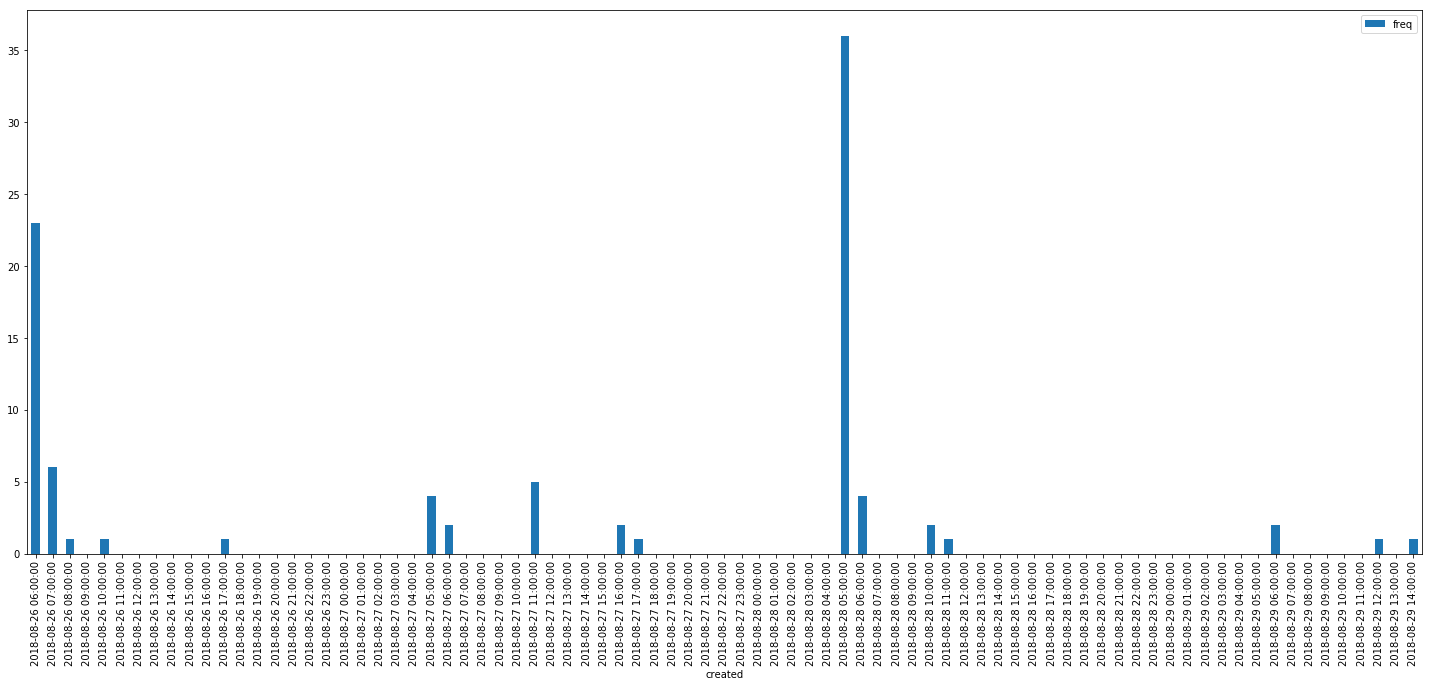

In [15]:
part = data[['created', 'freq']].copy()
part = part.set_index('created').resample('60Min').sum().plot(kind="bar", figsize=[25, 10])
